# **Spooky Season Image Generation**

## Summary
This notebook explores using a large language model to assist with prompt engineering for image generation via stable diffusion.  To kick off the month of October, I chose the theme of "spooky season" which was inspired by chilly Fall evenings, classic horror movies and Halloween night.  Please check out this [Instagram page](https://www.instagram.com/spooky_data_science/) if you would like to follow along.


## Contents
* Text-to-Image Prompts
* Image Generation using Stable Diffusion
* Instagram Description w/ Hashtags

---
# **Environment**

In [1]:
import pandas as pd
import os
import io
import warnings
from PIL import Image

from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation
from langchain.llms import OpenAI

import re
import nltk

from dev import (
    OPENAI_API_KEY, 
    STABILITYAI_API_KEY, 
)

In [2]:
# set environment variables
os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'
os.environ['STABILITY_KEY'] = STABILITYAI_API_KEY

---
# **Text-to-Image Prompts**
With some iteration, I found that I liked the stable diffusion results best with art styles of cartoon, anime, sketch and retro, which is why I specified those below.  The more realistic art styles produced some amazing results, but they also resulted in outright nightmare fuel.  I wanted to keep it "spooky" without deviating too much into "terrifying".

In [3]:
# initialize LLM
llm = OpenAI(openai_api_key=OPENAI_API_KEY, model_name="text-davinci-003")

In [4]:
# provide context
text_to_image_prompts = llm("""
I have a YouTube channel where I discuss horror movies.  
I want to use a text-to-image model to generate background images for my videos.  
The images should be inspired by Halloween night, classic horror movies and spooky Fall evenings.
Please include some prompts with jack-o-lanterns, vampires, zombies, ghosts and other monsters.
Write 10 text-to-image prompts using different art styles based on the information provided above.
Specifiy the art style at the beginning of each prompt, and provide a detailed description of the background.
Limit the art styles to Cartoon, Anime, Sketch and Retro.
""")

# print response
print(text_to_image_prompts)


1. Cartoon: A dark, moonlit night with a jack-o-lantern glowing brightly in the foreground, and a creepy graveyard filled with spooky tombstones in the background.
2. Anime: A full moon shining down on a secluded pumpkin patch, with a mysterious figure lurking in the shadows. 
3. Sketch: A foggy night with a haunted house in the distance, and a silhouette of a vampire in the foreground.
4. Retro: A starry night sky with a large haunted castle in the background, and a werewolf howling in the foreground.
5. Cartoon: A bright orange harvest moon illuminating a creepy forest, with a witch flying on a broomstick over a cemetery.
6. Anime: A misty night with an old abandoned mansion, and a group of zombies slowly walking towards it in the foreground.
7. Sketch: A dark and stormy night filled with lightning and silhouettes of ghosts flying through the sky.
8. Retro: A dark, foggy night with a full moon in the sky, and a haunted forest in the background.
9. Cartoon: A cozy Fall evening with a

---
# **Image Generation using Stable Diffusion**
The code below was largely borrowed from the Stability AI docs.  I usually iterated through this section several times, trying different art styles for the same prompt, and sometimes removing elements from the prompt to clean up the image.

In [5]:
# connect to API
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'],
    verbose=True,
    engine="stable-diffusion-xl-1024-v1-0",
)

In [9]:
# add prompt for image
chosen_prompt = "Sketch: A dark, moonlit night with a jack-o-lantern glowing brightly in the foreground, and a creepy graveyard filled with spooky tombstones in the background."

In [10]:
# initial generation parameters
answers = stability_api.generate(
    prompt=chosen_prompt,
    seed=22,
    steps=50,
    cfg_scale=8.0,
    width=1024,
    height=1024,
    samples=1,
    sampler=generation.SAMPLER_K_DPMPP_2M
)

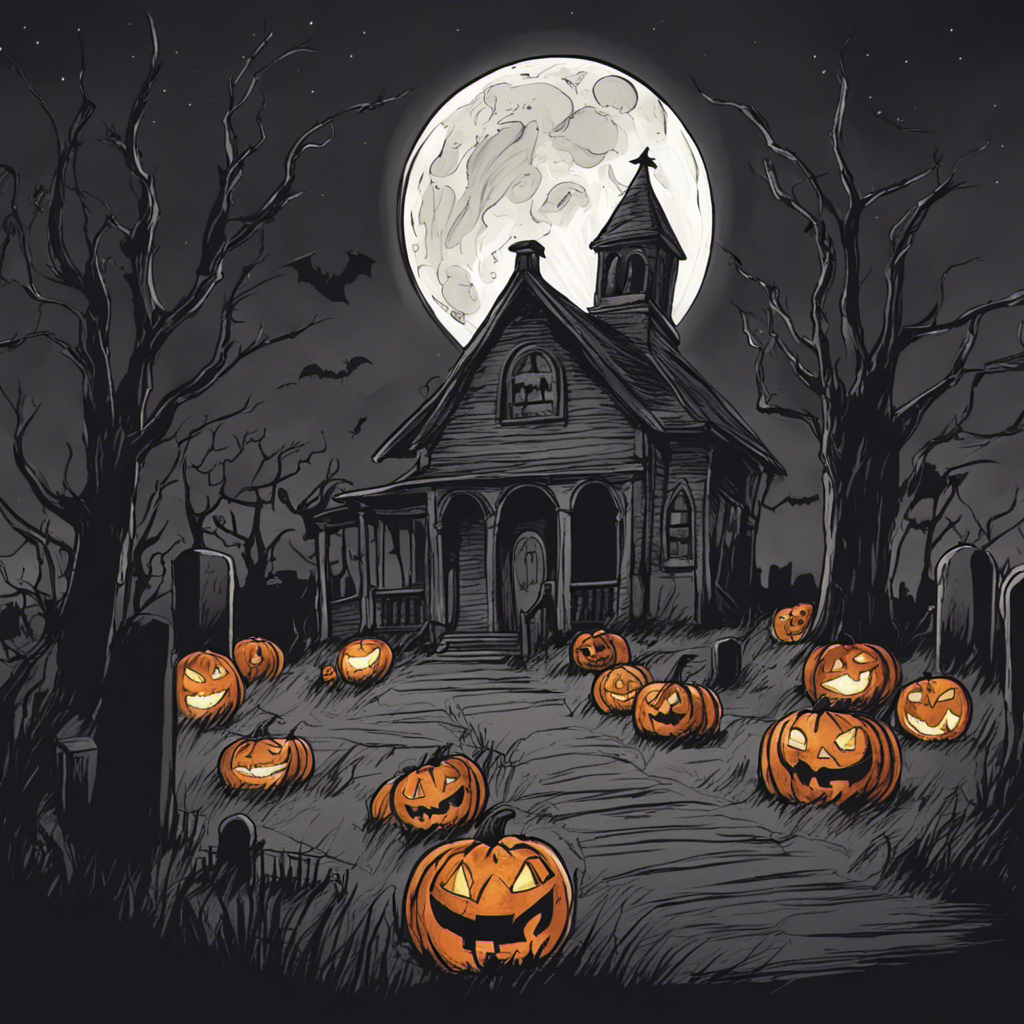

In [11]:
# create a warning to print to the console if the adult content classifier is tripped and halt save
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            img.save("20231006_sketch_jackolantern_graveyard_seed" + str(artifact.seed) + ".png") # save image
            
# show image
img

---
# **Instagram Description w/ Hashtags**
This section uses NLP to craft a description for my Instagram upload.  I will investigate an automated approach as a next step to this notebook.

In [12]:
# convert a prompt to a description w/ hashtags for Instagram
def insta_description_builder(prompt: str) -> str:
    """
    Args:
        prompt: the text prompt used to generate an image for Instagram.
        
    Returns description for Instagram with relevant hashtags.
    """
    modified_prompt = re.sub(r'[^\w\s]', '', str(prompt).lower().strip())
    prompt_tokens = modified_prompt.split()
    stopwords = nltk.corpus.stopwords.words("english")
    hashtags = ['#' + word for word in prompt_tokens if word not in stopwords]
    hashtags = ' '.join(hashtags)
    insta_description = print(prompt + '\n' + '#spookyseason #aiart #aiartwork ' + hashtags)
    return insta_description

In [13]:
# generate description for chosen prompt
insta_description_builder(chosen_prompt)

Sketch: A dark, moonlit night with a jack-o-lantern glowing brightly in the foreground, and a creepy graveyard filled with spooky tombstones in the background.
#spookyseason #aiart #aiartwork #sketch #dark #moonlit #night #jackolantern #glowing #brightly #foreground #creepy #graveyard #filled #spooky #tombstones #background
